In [13]:
%matplotlib inline

# General
import os
import re
import sys
import json
import pathlib
import hashlib
import requests
import tqdm
import pprint

from typing import Dict, List, Union

# Data munging
import pandas as pd
import numpy as np

from pandas import Series
from pandas import DataFrame

# Visualisation libraries
import altair as alt
import matplotlib.pyplot as plt

# ML imports
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE

This case study requires the following version of Python

In [14]:
sys.version

'3.6.5 (default, May 11 2018, 04:00:52) \n[GCC 8.1.0]'

### Project Structure

This case study has been split into the following sections:

1. [Project Settings](#Project-Settings)
2. [Data Retreival](#Data-Retreival)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Modeling](#Modeling)

### Project Settings

In [2]:
# Directories and file paths
ROOT_DIR = pathlib.Path('.')
DATA_DIR = ROOT_DIR.joinpath('data')
DATA_FILE = DATA_DIR.joinpath('covtype.data.gz')

# Data related URIs
UCI_URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/'

# Target and feature mappings
TARGET_MAPPING = {
    1: 'Spruce/Fir',
    2: 'Lodgepole Pine',
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas-fir',
    7: 'Krummholz'
}

WILDERNESS_MAPPING = {
    'Wilderness_Area_0': 'Rawah Wilderness Area',
    'Wilderness_Area_1': 'Neota Wilderness Area',
    'Wilderness_Area_2': 'Comanche Peak Wilderness Area',
    'Wilderness_Area_3': 'Cache la Poudre Wilderness Area'
}

# Plotting
pct_formatter = plt.FuncFormatter(lambda x, y: f"{x:.0%}")

### Data Retreival

The functions below download the cover type data set and associated information from the UCI Machine Learning Repository. These files are stored in the `DATA_DIR` directory defined in the [project settings](#Project-Settings). For each file downloaded a hash is calculated and stored in the `data/hashes.json` file. For this particular version of the notebook the hash is specified in the [Exploratory Data Analysis](#Exploratory-Data-Analysis) section below.

In [5]:
def md5_hash(content: bytes) -> str:
    """Helper function to generate an md5 hash given some content.
    
    Args:
        content (bytes): Bytes content to be hashed
        
    Returns:
        The hexdigest of a md5 hash
    """
    md5 = hashlib.md5()
    md5.update(resp.content)
    return md5.hexdigest()

def download_data() -> Dict:
    """Fetch the data from the uci repository.
    
    The repository consists of the actual dataset as well as some descriptive information.
    
    Returns:
        A dict of file hashes
    """
    resp = requests.get(UCI_URI)
    resp.raise_for_status()
    
    pattern = re.compile('href="([\w.]+)"')
    matches = pattern.findall(resp.text)
    
    hashes = {}
    for match in tqdm.tqdm(matches):
        try:
            # Fetch the relevant file
            resp = requests.get(f"{UCI_URI}{match}")
            resp.raise_for_status()
            
            hashes[match] = md5_hash(resp.content)

            # Remove the file if it already exists
            filepath = DATA_DIR.joinpath(match)
            if filepath.exists():
                os.remove(filepath.absolute())
                
            # Write the file disk
            with open(filepath.absolute(), 'wb') as f:
                f.write(resp.content)
        except:
            continue
            
    # Save the file hashes
    filepath = DATA_DIR.joinpath('hashes.json')
        
    with open(filepath.absolute(), 'w') as f:
        json.dumps(hashes, indent=4)
            
    return hashes

hashes = download_data()

100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


The files downloaded include the actual data set as well as a description of the data set. The files we are interested in are the `covtype.info` and `covtype.data.gz`.

The `covtype.info` file contains detailed information on the data set including the sources of the data, past usage, the problem description and schema. To read the contents of the `covtype.info` file try opening it in a text editor or just run `%cat data/covtype.info` in a notebook cell.

The actual data is available in a gzipped csv file within `covtype.data.gz`.

In [6]:
# %cat data/covtype.info | head -n 20

In [7]:
# The download function produces a list of files and their md5 hashes
hashes

{}

### Exploratory Data Analysis

Before any modelling can begin we should conduct some EDA on the dataset.

This analysis makes use of the `covtype.data.gz` file with the following hash **da67cb1aec8c1b2a40a1d6522934aed4**.

The data set contains 581,012 samples, 54 features and a single column for the target values. 

Details for each feature can be seen below.

- Elevation (quantitative)
    - Elevation in meters
- Aspect (quantitative)
    - Aspect in degrees azimuth
- Slope (quantitative)
    - Slope in degrees
- Horizontal_Distance_To_Hydrology (quantitative)
    - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (quantitative)
    - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (quantitative)
    - Horz Dist to nearest roadway
- Hillshade_9am (quantitative)
    - Hillshade index at 9am, summer solstice
- Hillshade_Noon (quantitative)
    - Hillshade index at noon, summer soltice
- Hillshade_3pm (quantitative)
    - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points (quantitative)
    - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (qualitative) - Four binary features
    - Wilderness area designation
- Soil_Type (qualitative) - Fourty binary features
    - Soil Type designation
- Cover_Type (integer)
    - Forest Cover Type designation
    
    
Our target variable for this data set is contained in the Cover_Type column. This field contains categorical data which map to the following cover types:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

This section is broken down into the following sub sections:

1. Data loading
2. Class imbalance

In [111]:
# The data set does not contain headers so we must first generate them
names = [    
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# Create a copy of all the feature names
quantitative_features_names = [feature for feature in names]
wilderness_features = [f"Wilderness_Area_{i}" for i in range(4)]
soil_type_features = [f"Soil_Type_{i}" for i in range(40)]

names += wilderness_features
names += soil_type_features

# Create a copy of all the feature names
features_names = [feature for feature in names]

names.append('Cover_Type')

# Read the csv file using the pandas read_csv function
covertype = pd.read_csv(
    DATA_FILE,
    names=names
)

By examining the parsed data frame we can confirm that the data set contains 581,012 samples and that each of the fields has been parsed as an `int64` dtype. Although the Wilderness_Area and Soil_Type features are binary features, representing them as `int64` data is sufficient as they are stored in a one-hot-encoded fashion. Later in this notebook we will convert all the dtypes to `float64` as scitkit-learn makes the assumption that all data is floating point data.

Another important take away is that none of the features have any missing values which is confirmed under Section 9 of the `covertype.info` file.

In [112]:
covertype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area_0                     581012 non-null int64
Wilderness_Area_1                     581012 non-null int64
Wilderness_Area_2                     581012 non-null int64
Wilderness_Area_3                     581012 non-null int64
Soil_Type_0                           581012 non-

In [113]:
covertype[features_names] = covertype[features_names].astype(float)
covertype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null float64
Aspect                                581012 non-null float64
Slope                                 581012 non-null float64
Horizontal_Distance_To_Hydrology      581012 non-null float64
Vertical_Distance_To_Hydrology        581012 non-null float64
Horizontal_Distance_To_Roadways       581012 non-null float64
Hillshade_9am                         581012 non-null float64
Hillshade_Noon                        581012 non-null float64
Hillshade_3pm                         581012 non-null float64
Horizontal_Distance_To_Fire_Points    581012 non-null float64
Wilderness_Area_0                     581012 non-null float64
Wilderness_Area_1                     581012 non-null float64
Wilderness_Area_2                     581012 non-null float64
Wilderness_Area_3                     581012 non-null float64
Soil_Type_0          

### Class Distribution

Below I examine the class distribution of the target variable. The data set is clearly imbalanced wh0ch is something that should be taken into account during modelling depending on what model is chosen.

Specifically the Lodgepole Pine and Spruce/Fir cover types make up the majority of the data set, cumulatively accounting for 85% of the samples.

In [34]:
class_distribution = covertype['Cover_Type'].value_counts(True)
class_distribution_named = Series(class_distribution.values, index=class_distribution.index.map(TARGET_MAPPING))

In [36]:
covertype['Cover_Type'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [32]:
# Class distribution percentage
class_distribution_named.apply(lambda x: f"{x:.1%}")

Lodgepole Pine       48.8%
Spruce/Fir           36.5%
Ponderosa Pine        6.2%
Krummholz             3.5%
Douglas-fir           3.0%
Aspen                 1.6%
Cottonwood/Willow     0.5%
dtype: object

In [33]:
# Cumulative class distribution cumulative percentage
(class_distribution_named
    .cumsum()
    .apply(lambda x: f"{x:.1%}")
)

Lodgepole Pine        48.8%
Spruce/Fir            85.2%
Ponderosa Pine        91.4%
Krummholz             94.9%
Douglas-fir           97.9%
Aspen                 99.5%
Cottonwood/Willow    100.0%
dtype: object

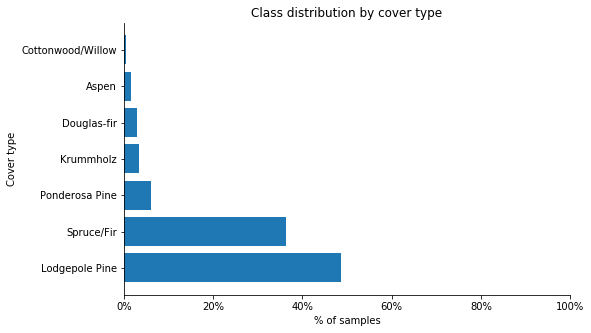

In [98]:
fig, ax = plt.subplots(figsize=(8, 5))

x = class_distribution_named.index.values
y = class_distribution.values

ax.barh(x, y)
ax.set_xlim(0, 1)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.xaxis.set_major_formatter(pct_formatter)
ax.set_ylabel('Cover type')
ax.set_xlabel('% of samples')
ax.set_title('Class distribution by cover type')
plt.show()

The following section looks at the wilderness area and soil types in more detail. Both these sets of features are provided as one hot encoded binary features. This means that each feature is a binary variable which either indicates a sample is of the specific feature or is not. For example, the wilderness area 1 (Wilderness_Area_0 in the data set) refers to the Rawah Wilderness Area in North America. A given sample will either be part of this area or not. In this next section I hope to understand more about the cover types based on the wilderness area and soil type. Some of the questions we may be able to answer include:

1. Are there cover types unique to certain wilderness areas?
1. Are there cover types which only grow or thrive in a particular soil type?

In order to achieve the above I have decided to summarize the wilderness area and soil type features by cover type. This summarised data is then normalized so that each value gives the percentage by cover type and wilderness/soil type. This way it will be more meaningful as we have already seen above Spruce/Fir and Lodgepole Pine trees make up the majority of the data set. 

Given this, for each set of features (wilderness area and soil type) I have produced two heatmaps. The first heatmap shows the distribution of trees by wilderness area/soil type. Looking at the wilderness area section below we can see that Lodgepole Pine and Spruce/Fir trees make up the majority of cover types in all the wilderness areas except the Cache la Poudre wilderness area. The Cache la Poudre area is mostly covered by Ponderosa Pine and Douglas-fir trees. 

The second heatmap in the set shows the distribution of cover type over the wilderness area/soil type. If we examine the wilderness area section immediately the Cottonwood/Willow cover types stand out as they can only be found in the Cache la Poudre wilderness area.

Examining the two charts for soil types we can also see similar seperations. For example if we look at the second heatmap in the soil type section we can see that approximately 51% of the Douglas-fir cover type can be found on land classified as soil type 9. Looking at the `covtype.info` file we can see that soil type 9 refers to the `Troutville family, very stony` soil type.

So far it seems as if these features provide useful information in seperating the cover types.

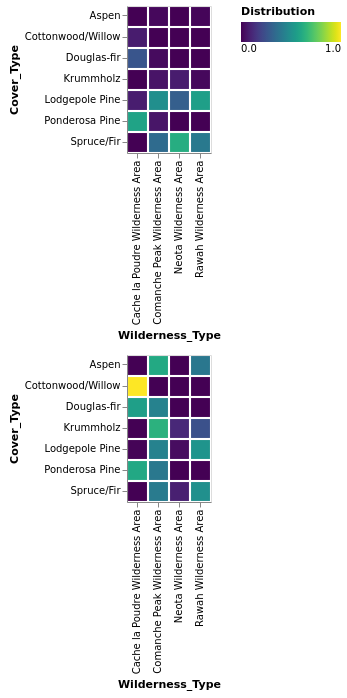

In [201]:
group = covertype.groupby('Cover_Type')
wilderness_area = group[wilderness_features].sum()

wilderness_area_named = DataFrame(
    wilderness_area.values,
    columns=wilderness_area.columns.map(WILDERNESS_MAPPING),
    index=wilderness_area.index.map(TARGET_MAPPING)
)

cover_type_by_wilderness_area = wilderness_area_named.divide(wilderness_area_named.sum(axis=0), axis=1)
wilderness_area_by_cover_type = wilderness_area_named.divide(wilderness_area_named.sum(axis=1), axis=0)

def prepare_frame_for_charting(frame: DataFrame) -> DataFrame:
    """Prepare the given data frame for plotting
    Args:
        frame (DataFrame): 
    
    Returns:
        A DataFrame to be plotted
    """
    return (
        frame
            .unstack()
            .reset_index()
            .rename(columns={'level_0': 'Wilderness_Type', 0: 'Distribution'})
    )

# Plot the data
cover_type_by_wilderness_area_chart = (
    alt
        .Chart(prepare_frame_for_charting(cover_type_by_wilderness_area))
        .mark_rect()
        .encode(
            x='Wilderness_Type:O',
            y='Cover_Type:O',
            color='Distribution:Q',
            tooltip='Distribution'
        )
)

wilderness_area_by_cover_type_chart = (
    alt
        .Chart(prepare_frame_for_charting(wilderness_area_by_cover_type))
        .mark_rect()
        .encode(
            x='Wilderness_Type:O',
            y='Cover_Type:O',
            color='Distribution:Q',
            tooltip='Distribution'
        )
)

cover_type_by_wilderness_area_chart & wilderness_area_by_cover_type_chart

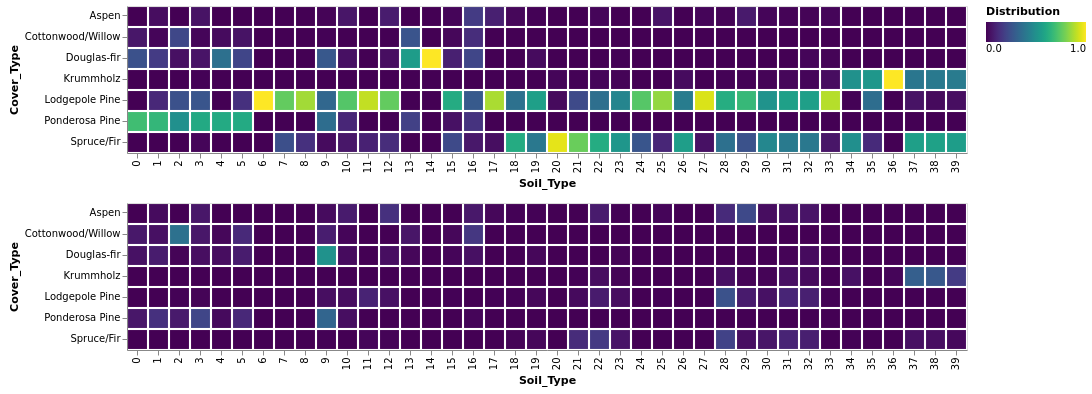

In [199]:
group = covertype.groupby('Cover_Type')
soil_type = group[soil_type_features].sum()
soil_type_named = DataFrame(
    soil_type.values, 
    index=soil_type.index.map(TARGET_MAPPING)
)

cover_type_by_soil_type = soil_type_named.divide(soil_type_named.sum(axis=0), axis=1) # Cover type by soil type
soil_type_by_cover_type = soil_type_named.divide(soil_type_named.sum(axis=1), axis=0) # Soil type by cover type

def prepare_frame_for_charting(frame: DataFrame) -> DataFrame:
    """Prepare the given data frame for plotting
    Args:
        frame (DataFrame): 
    
    Returns:
        A DataFrame to be plotted
    """
    return (
        frame
            .unstack()
            .reset_index()
            .rename(columns={'level_0': 'Soil_Type', 0: 'Distribution'})
    )

# Plot the data
cover_type_by_soil_type_chart = (
    alt
        .Chart(prepare_frame_for_charting(cover_type_by_soil_type))
        .mark_rect()
        .encode(
            x='Soil_Type:O',
            y='Cover_Type:O',
            color='Distribution:Q',
            tooltip='Distribution'
        )
)

soil_type_by_cover_type_chart = (
    alt
        .Chart(prepare_frame_for_charting(soil_type_by_cover_type))
        .mark_rect()
        .encode(
            x='Soil_Type:O',
            y='Cover_Type:O',
            color='Distribution:Q',
            tooltip='Distribution'
        )
)

cover_type_by_soil_type_chart & soil_type_by_cover_type_chart

## Modeling

For the classification I have decided to use the following models:

1. Logistic Regression (Should provide reasonable performance on the data set)
2. Random Forests
3. Gradient Boosted Descision Tree

I also want to assess whether a downsampled dataset can provide equally good generalisation. This will help not only in performance but also in visualisation.

For starters I will use a logistic regression model with standardised features as a base model to assess whether the subsequent attempts are useful.

## Base Line

Below I have created logistic regression model using scaled data with the scikit-learn StandarScaler. The model splits the data set with the `train_test_split` function using the default parameters. Given this the training set is quite large and the time to train is long. However the accuracy is not terrible and by examining the predicted classes we can see that the model has made predictions for all the classes and not only the majority classes identified above.

In [10]:
y = covertype.Cover_Type.values
X = covertype[features_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=0)
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
predicted_classes = model.predict(X_test_scaled)
predicted_classes_unique = np.unique(predicted_classes)

print('Model accuracy', accuracy)
print('Predicted classes', predicted_classes_unique)

Model accuracy 0.715248566294672
Predicted classes [1 2 3 4 5 6 7]


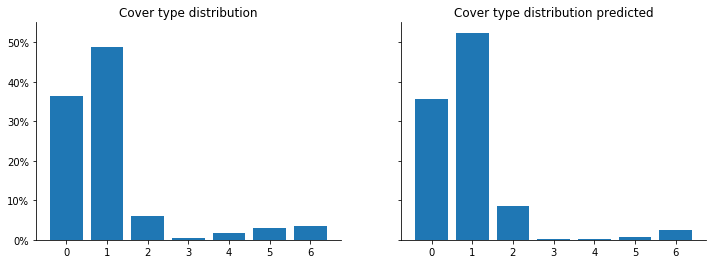

In [46]:
distribution = covertype.Cover_Type.value_counts(True, sort=False).values
distribution_predicted = np.bincount(predicted_classes)[1:] / np.sum(np.bincount(predicted_classes)[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax1.bar(range(len(distribution)), distribution)
ax2.bar(range(len(distribution_predicted)), distribution_predicted)

ax1.set_title('Cover type distribution')
ax2.set_title('Cover type distribution predicted')

for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
    
ax1.yaxis.set_major_formatter(pct_formatter)

## Sampling

In this section I will attempt to extract a sample from the data set to aid with training performance and hopefully improve generalization. For a given sample size the data per class is either down sampled or up sampled. The details of the latter can be seen in `extract_sample` below.

In [89]:
covertype.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [114]:
def extract_sample(n_samples: int) -> DataFrame:
    """Extracts a sample from the covertype DataFrame. 
    
    Specifically this function splits the cover type DataFrame into a DataFrame
    for each target value and then either up or down samples the data based on the value
    of n_samples. If n_samples is less than the number of samples for the specified class
    the data will be up sampled. If n_samples is more than the samples in the specified class
    the data will be down sampled.
    
    Args:
        n_samples (int): The number of samples to extract from the covertype DataFrame
    
    Returns:
        A DataFrame sampled from the cover type DataFrame
    """
    ctypes = covertype.Cover_Type.unique().tolist()

    frames = []
    for ctype in ctypes:
        frame = covertype.loc[covertype.Cover_Type == ctype]

        frames.append(
            resample(
                frame,
                replace=len(frame) < n_samples,
                n_samples=n_samples,
                random_state=0
            )
        )

    return pd.concat(frames)
    
covertype_sampled = extract_sample(n_samples)

len(covertype_sampled)

35000

In [115]:
y = covertype_sampled.Cover_Type.values
X = covertype_sampled[features_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [116]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=0)

model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
predicted_classes = model.predict(X_test_scaled)
predicted_classes_unique = np.unique(predicted_classes)

print('Model accuracy', accuracy)
print('Predicted classes', predicted_classes_unique)

Model accuracy 0.6811428571428572
Predicted classes [1 2 3 4 5 6 7]


In [91]:
tsne = TSNE()
transformed = tsne.fit_transform(X, y)

In [168]:
y = covertype_sampled.Cover_Type.values
X = covertype_sampled[features_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

test_accuracies = []
train_accuracies = []

max_depths = range(0, 30, 5)
for max_depth in max_depths[1:]:
    model = RandomForestClassifier(n_estimators=20, n_jobs=2, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)

    test_accuracy = model.score(X_test, y_test)
    train_accuracy = model.score(X_train, y_train)
    
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

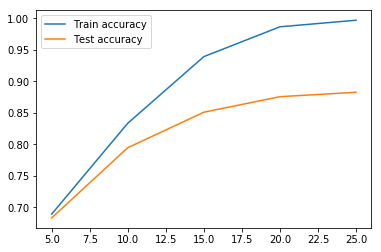

In [173]:
plt.plot(max_depths[1:], train_accuracies, label='Train accuracy')
plt.plot(max_depths[1:], test_accuracies, label='Test accuracy')
plt.legend()

In [175]:
model = RandomForestClassifier(n_estimators=20, n_jobs=2, max_depth=20, random_state=0)
model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
train_accuracy = model.score(X_train, y_train)

print('Test accuracy', test_accuracy)
print('Train accuracy', train_accuracy)

print(
    model.score(covertype[features_names].values, covertype.Cover_Type.values)
)

Test accuracy 0.8758857142857143
Train accuracy 0.9868190476190476
0.7655160306499693


In [177]:
X = covertype[features_names].values
y = covertype.Cover_Type.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = RandomForestClassifier(n_estimators=20, n_jobs=2, max_depth=20, random_state=0)
model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
train_accuracy = model.score(X_train, y_train)

print('Test accuracy', test_accuracy)
print('Train accuracy', train_accuracy)

Test accuracy 0.8933102930748418
Train accuracy 0.9242081058566777
